<a href="https://colab.research.google.com/github/QuantJackson/11785_hw2p2/blob/main/HW2P2_Student_Starter_Spring25_0.024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW2P2: Image Recognition and Verification

This is the second homework  in 11785: Introduction to Deep Learning. We are trying to tackle the problem of Image Verification. For this, we will need to first train our own CNN model to tackle the problem of classification, consisting of 8631 identities. Using this, we get the face embeddings for different pairs of images and try to identify if the pair of face matches or not.

# Libraries

In [1]:
!nvidia-smi

Mon Feb 24 00:17:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   78C    P0             35W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install wandb --quiet
!pip install pytorch_metric_learning --quiet

In [3]:
!pip install torchsummary --quiet
!pip install torchvision --quiet

TODO: Change Imports based on new dataset

In [4]:
import torch
from torchsummary import summary
import torchvision
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [5]:
from google.colab import drive # Link to your drive if you are not using Colab with GCP
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Kaggle

In [6]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade kaggle==1.6.17 --force-reinstall --no-deps
!mkdir /root/.kaggle


with open("/root/.kaggle/kaggle.json", "w+") as f:
    # Put your kaggle username & key here
    f.write('{"username":"junchengshe","key":"6b20a16e2efb0cb305430ce1e732358c"}')
!chmod 600 /root/.kaggle/kaggle.json


  Using cached kaggle-1.6.17-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [7]:
# # Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw-2-p-2-face-verification-spring-2025
!unzip -qo '11785-hw-2-p-2-face-verification-spring-2025' -d '/content/data'

mkdir: cannot create directory ‘/content/data’: File exists
11785-hw-2-p-2-face-verification-spring-2025.zip: Skipping, found more recently modified local copy (use --force to force download)


# Config

In [8]:
config = {
    'batch_size': 1024, # Increase this if your GPU can handle it
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'num_classes': 8631, #Dataset contains 8631 classes for classification, reduce this number if you want to train on a subset, but only for train dataset and not on val dataset
    'cls_data_dir': "/content/data/HW2p2_S25/cls_data", #TODO: Provide path of classification directory
    'ver_data_dir': "/content/data/HW2p2_S25/ver_data", #TODO: Provide path of verification directory
    'val_pairs_file': "/content/data/HW2p2_S25/val_pairs.txt", #TODO: Provide path of text file containing val pairs for verification
    'test_pairs_file': "/content/data/HW2p2_S25/test_pairs.txt", #TODO: Provide path of text file containing test pairs for verification
    'checkpoint_dir': "/content/data/checkpoints", #TODO: Checkpoint directory
    'augument': True
    # Include other parameters as needed.
}

# Dataset

In [9]:
import random
def create_transforms(image_size: int = 112, augment: bool = True) -> T.Compose:
    """Create transform pipeline for face recognition."""

    # Step 1: Basic transformations
    transform_list = [
        # Resize the image to the desired size (image_size x image_size)
        T.Resize((image_size, image_size)),

        # Convert PIL Image to tensor
        T.ToTensor(),

        # Convert image to float32 and scale the pixel values to [0, 1]
        T.ToDtype(torch.float32, scale=True),
    ]

    # Step 2: Data augmentation (optional, based on `augment` argument)
    if augment:  # This block will be executed if `augment=True`
        # TODO: Add transformations for data augmentation (e.g., random horizontal flip, rotation, etc.)
        # Example:
      random_choice_transform = random.choice([torchvision.transforms.RandomHorizontalFlip(p=0.7),
                      torchvision.transforms.RandomRotation(10)])
      whether_gauss = random.random() > 0.3
      if whether_gauss:
        transform_list.extend([random_choice_transform] + [torchvision.transforms.GaussianBlur(3,(0.5,1.5))])
      else:
        transform_list.extend([random_choice_transform])

    # Step 3: Standard normalization for image recognition tasks
    # The Normalize transformation requires mean and std values for each channel (R, G, B).
    # Here, we are normalizing the pixel values to have a mean of 0.5 and std of 0.5 for each channel.
    transform_list.extend([
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Standard mean and std for face recognition tasks
    ])

    # Return the composed transformation pipeline
    return T.Compose(transform_list)


## Classification Datasets and Dataloaders

In [10]:
class ImageDataset(torch.utils.data.Dataset):
    """Custom dataset for loading image-label pairs."""
    def __init__(self, root, transform, num_classes=config['num_classes']):
        """
        Args:
            root (str): Path to the directory containing the images folder.
            transform (callable): Transform to be applied to the images.
            num_classes (int, optional): Number of classes to keep. If None, keep all classes.
        """
        self.root = root
        self.labels_file = os.path.join(self.root, "labels.txt")
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = set()

        # Read image-label pairs from the file
        with open(self.labels_file, 'r') as f:
            lines = f.readlines()

        lines = sorted(lines, key=lambda x: int(x.strip().split(' ')[-1]))

        # Get all unique labels first
        all_labels = sorted(set(int(line.strip().split(' ')[1]) for line in lines))

         # Select subset of classes if specified
        if num_classes is not None:
            selected_classes = set(all_labels[:num_classes])
        else:
            selected_classes = set(all_labels)

        # Store image paths and labels with a progress bar
        for line in tqdm(lines, desc="Loading dataset"):
            img_path, label = line.strip().split(' ')
            label = int(label)

            # Only add if label is in selected classes
            if label in selected_classes:
                self.image_paths.append(os.path.join(self.root, 'images', img_path))
                self.labels.append(label)
                self.classes.add(label)

        assert len(self.image_paths) == len(self.labels), "Images and labels mismatch!"

        # Convert classes to a sorted list
        self.classes = sorted(self.classes)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image, label)
        """
        # Load and transform image on-the-fly
        image = Image.open(self.image_paths[idx]).convert('RGB')
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

gc.collect()

259

In [11]:
# train transforms
train_transforms = create_transforms(augment=config['augument'])

# val transforms
val_transforms   = create_transforms(augment=False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [12]:
# Datasets
cls_train_dataset = ImageDataset(root=os.path.join(config["cls_data_dir"],"train"), transform=train_transforms)
cls_val_dataset   = ImageDataset(root=os.path.join(config["cls_data_dir"],"dev"), transform=val_transforms)
cls_test_dataset  = ImageDataset(root=os.path.join(config["cls_data_dir"],"test"), transform=val_transforms)

assert cls_train_dataset.classes == cls_val_dataset.classes == cls_test_dataset.classes, "Class mismatch!"


# Dataloaders
cls_train_loader = DataLoader(cls_train_dataset, batch_size=config['batch_size'], shuffle=True,  num_workers=4, pin_memory=True)
cls_val_loader   = DataLoader(cls_val_dataset,   batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)
cls_test_loader  = DataLoader(cls_test_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=4, pin_memory=True)

Loading dataset: 100%|██████████| 43155/43155 [00:00<00:00, 613776.65it/s]


## Verification Dataset and Datatloaders

In [13]:
class ImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.matches     = []
        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2, match = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)
            self.matches.append(int(match))  # Convert match to integer

        assert len(self.image1_list) == len(self.image2_list) == len(self.matches), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        match = self.matches[idx]
        return self.transform(img1), self.transform(img2), match


In [14]:
class TestImagePairDataset(torch.utils.data.Dataset):
    """Custom dataset for loading and transforming image pairs."""
    def __init__(self, root, pairs_file, transform):
        """
        Args:
            root (str): Path to the directory containing the images.
            pairs_file (str): Path to the file containing image pairs and match labels.
            transform (callable): Transform to be applied to the images.
        """
        self.root      = root
        self.transform = transform

        self.image1_list = []
        self.image2_list = []

        # Read and load image pairs and match labels
        with open(pairs_file, 'r') as f:
            lines = f.readlines()

        for line in tqdm(lines, desc="Loading image pairs"):
            img_path1, img_path2 = line.strip().split(' ')
            img1 = Image.open(os.path.join(self.root, img_path1)).convert('RGB')
            img2 = Image.open(os.path.join(self.root, img_path2)).convert('RGB')

            self.image1_list.append(img1)
            self.image2_list.append(img2)

        assert len(self.image1_list) == len(self.image2_list), "Image pair mismatch"

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.image1_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (transformed image1, transformed image2, match label)
        """
        img1 = self.image1_list[idx]
        img2 = self.image2_list[idx]
        return self.transform(img1), self.transform(img2)


In [15]:
# Datasets
ver_val_dataset  = ImagePairDataset(root=config['ver_data_dir'], pairs_file=config['val_pairs_file'], transform=val_transforms)
ver_test_dataset = TestImagePairDataset(root=config['ver_data_dir'], pairs_file=config['test_pairs_file'], transform=val_transforms)

# Dataloader
ver_val_loader   = DataLoader(ver_val_dataset,  batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)
ver_test_loader  = DataLoader(ver_test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=8, pin_memory=True)


Loading image pairs: 100%|██████████| 6000/6000 [00:03<00:00, 1938.87it/s]


## Create Dataloaders for Image Recognition

# EDA and Viz

In [16]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(cls_train_dataset.classes))
print("No. of train images  : ", cls_train_dataset.__len__())
print("Shape of image       : ", cls_train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", cls_train_loader.__len__())
print("Val batches          : ", cls_val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  1024
Train batches        :  422
Val batches          :  43


###Classification Dataset Viz

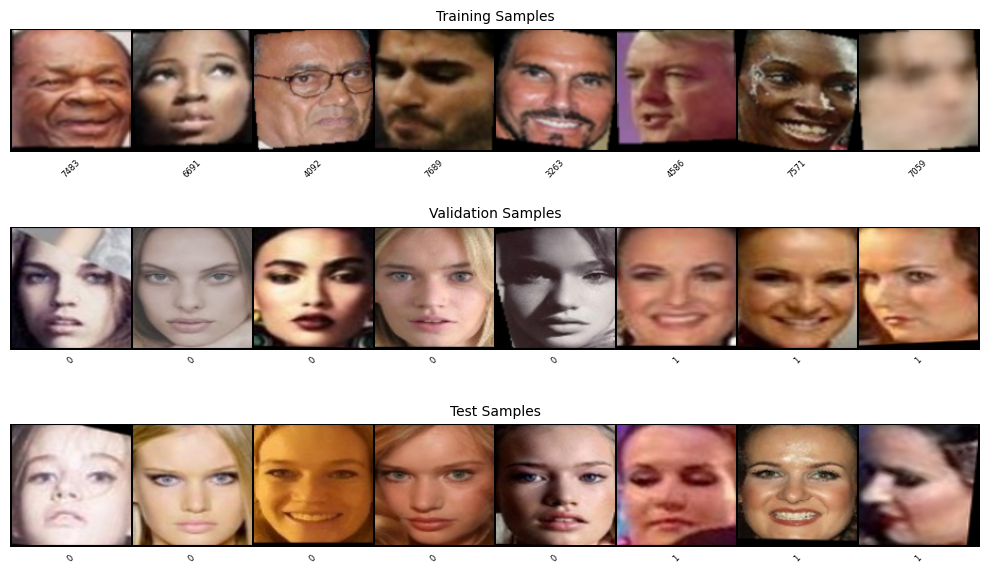

In [17]:
def show_cls_dataset_samples(train_loader, val_loader, test_loader, samples_per_set=8, figsize=(10, 6)):
    """
    Display samples from train, validation, and test datasets side by side

    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        samples_per_set: Number of samples to show from each dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n]

    # Get samples from each dataset
    train_imgs, train_labels = get_samples(train_loader, samples_per_set)
    val_imgs, val_labels = get_samples(val_loader, samples_per_set)
    test_imgs, test_labels = get_samples(test_loader, samples_per_set)

    # Create figure
    fig, axes = plt.subplots(3, 1, figsize=figsize)

    # Plot each dataset
    for idx, (imgs, labels, title) in enumerate([
        (train_imgs, train_labels, 'Training Samples'),
        (val_imgs, val_labels, 'Validation Samples'),
        (test_imgs, test_labels, 'Test Samples')
    ]):

        # Create grid of images
        grid = make_grid(denormalize(imgs), nrow=8, padding=2)

        # Display grid
        axes[idx].imshow(grid.permute(1, 2, 0).cpu())
        axes[idx].axis('off')
        axes[idx].set_title(title, fontsize=10)

        # Add class labels below images (with smaller font)
        grid_width = grid.shape[2]
        imgs_per_row = min(8, samples_per_set)
        img_width = grid_width // imgs_per_row

        for i, label in enumerate(labels):
            col = i % imgs_per_row  # Calculate column position
            if label<len(train_loader.dataset.classes):
              class_name = train_loader.dataset.classes[label]
            else:
              class_name = f"Class {label} (Unknown)"
            axes[idx].text(col * img_width + img_width/2,
                         grid.shape[1] + 5,
                         class_name,
                         ha='center',
                         va='top',
                         fontsize=6,
                         rotation=45)

    plt.tight_layout()
    plt.show()

show_cls_dataset_samples(cls_train_loader, cls_val_loader, cls_test_loader)

###Ver Dataset Viz

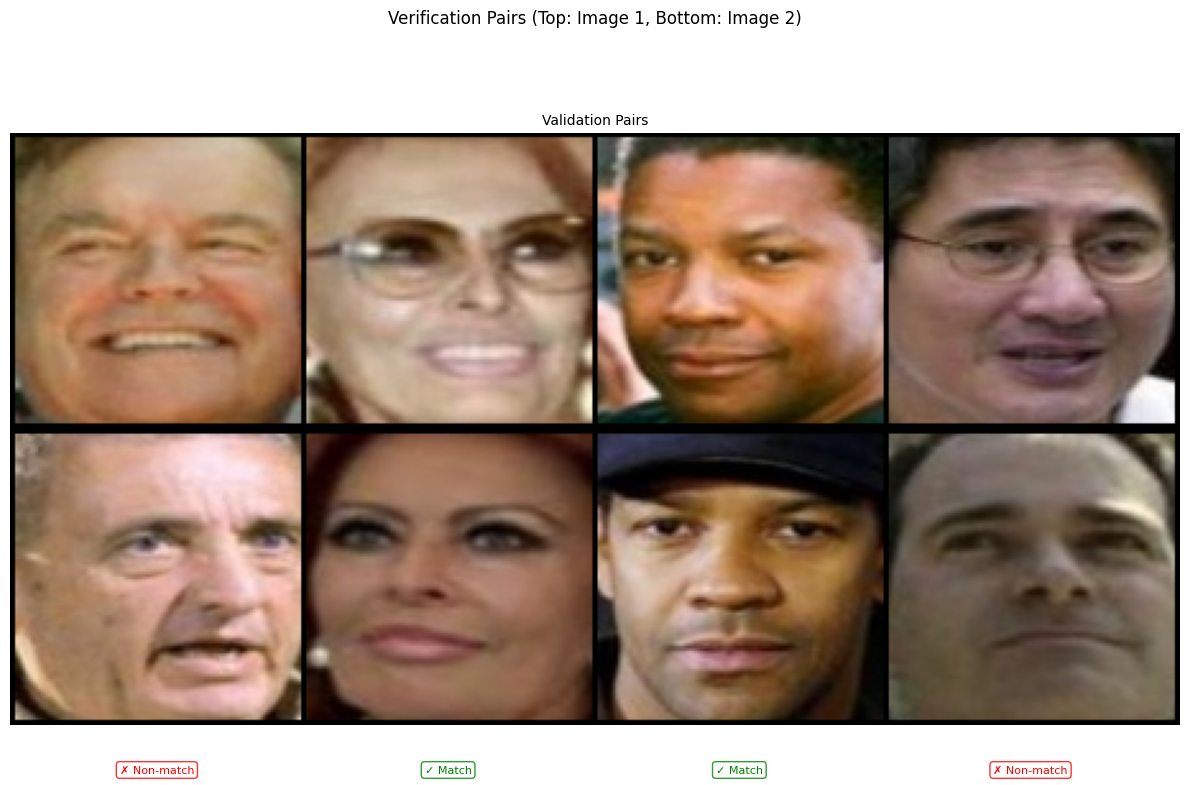

In [18]:
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid

def show_ver_dataset_samples(val_loader, samples_per_set=4, figsize=(12, 8)):
    """
    Display verification pairs from the validation dataset

    Args:
        val_loader: Validation data loader
        samples_per_set: Number of pairs to show from the dataset
        figsize: Figure size (width, height)
    """
    def denormalize(x):
        """Denormalize images from [-1, 1] to [0, 1]"""
        return x * 0.5 + 0.5

    def get_samples(loader, n):
        """Get n samples from a dataloader"""
        batch = next(iter(loader))
        return batch[0][:n], batch[1][:n], batch[2][:n]

    # Get samples from the validation dataset
    val_imgs1, val_imgs2, val_labels = get_samples(val_loader, samples_per_set)

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Create grids for both images in each pair
    grid1 = make_grid(denormalize(val_imgs1), nrow=samples_per_set, padding=2)
    grid2 = make_grid(denormalize(val_imgs2), nrow=samples_per_set, padding=2)

    # Combine the grids vertically
    combined_grid = torch.cat([grid1, grid2], dim=1)

    # Display the combined grid
    ax.imshow(combined_grid.permute(1, 2, 0).cpu())
    ax.axis('off')
    ax.set_title('Validation Pairs', fontsize=10)

    # Determine dimensions for placing the labels
    grid_width = grid1.shape[2]
    img_width = grid_width // samples_per_set

    # Add match/non-match labels for each pair
    for i, label in enumerate(val_labels):
        match_text = "✓ Match" if label == 1 else "✗ Non-match"
        color = 'green' if label == 1 else 'red'

        # Define a background box for the label
        bbox_props = dict(
            boxstyle="round,pad=0.3",
            fc="white",
            ec=color,
            alpha=0.8
        )

        ax.text(i * img_width + img_width / 2,
                combined_grid.shape[1] + 15,  # Position below the images
                match_text,
                ha='center',
                va='top',
                fontsize=8,
                color=color,
                bbox=bbox_props)

    plt.suptitle("Verification Pairs (Top: Image 1, Bottom: Image 2)", y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)
    plt.show()

show_ver_dataset_samples(ver_val_loader)


# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit for this homework is 30M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 112x112. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

In [19]:
import numpy as np
model_config = {
    "channels": np.array([1, 1, 2, 4, 8]) * 52,  # [64, 128, 256, 512]
    "weight_initialization": "kaiming_normal",
    "lr": 0.1,
    "weight_decay": 5e-4,
    "label_smoothing": 0.15,
}

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# 定义 Bottleneck 块，与标准 ResNet50 相同
class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, mid_channels, stride=1, downsample=None):
        """
        in_channels: 输入通道数
        mid_channels: 中间 1x1 和 3x3 卷积的输出通道数
        stride: 3x3 卷积的步长，用于下采样
        downsample: 如果需要调整 shortcut 分支时传入的模块
        """
        super(Bottleneck, self).__init__()
        # 第一层 1x1 卷积用于降低维度
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=1, bias=False)
        self.bn1   = nn.BatchNorm2d(mid_channels)
        # 第二层 3x3 卷积
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(mid_channels)
        # 第三层 1x1 卷积用于恢复通道数
        self.conv3 = nn.Conv2d(mid_channels, mid_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3   = nn.BatchNorm2d(mid_channels * self.expansion)
        self.relu  = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

# ResNet50 类似的网络结构
class ResNet50Modified(nn.Module):
    def __init__(self, num_classes, input_channels=3):
        super(ResNet50Modified, self).__init__()
        # Stem: 7×7 卷积 + BN + ReLU + 3×3 MaxPool（stride=2）
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, model_config["channels"][0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(model_config["channels"][0]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        # 定义四个阶段，块数与标准 ResNet50 保持一致
        self.layer1 = self._make_layer(Bottleneck, mid_channels=model_config["channels"][1], blocks=3, stride=1)
        self.layer2 = self._make_layer(Bottleneck, mid_channels=model_config["channels"][2], blocks=4, stride=2)
        self.layer3 = self._make_layer(Bottleneck, mid_channels=model_config["channels"][3], blocks=6, stride=2)
        self.layer4 = self._make_layer(Bottleneck, mid_channels=model_config["channels"][4], blocks=3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(model_config["channels"][4] * Bottleneck.expansion, num_classes)

        self.initialize_weights()

    def _make_layer(self, block, mid_channels, blocks, stride):
        downsample = None
        # 如果当前输入通道数与目标通道数不匹配，或需要下采样，则构造 downsample 模块
        if stride != 1 or self.in_channels != mid_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, mid_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(mid_channels * block.expansion)
            )
        layers = []
        layers.append(block(self.in_channels, mid_channels, stride, downsample))
        self.in_channels = mid_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, mid_channels))
        return nn.Sequential(*layers)

    def initialize_weights(self):
        # 采用 kaiming_normal 初始化
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if hasattr(m, "bias") and m.bias is not None:
                    m.bias.data.zero_()

    @property
    def in_channels(self):
        # 使用 self._in_channels 保存当前通道数
        if not hasattr(self, '_in_channels'):
            self._in_channels = model_config["channels"][0]
        return self._in_channels

    @in_channels.setter
    def in_channels(self, value):
        self._in_channels = value

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        out = self.fc(feats)
        return {"feats": feats, "out": out}

# 示例：初始化模型，并打印模型摘要
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Modified(num_classes=config["num_classes"]).to(DEVICE)
summary(model, (3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 52, 56, 56]           7,644
       BatchNorm2d-2           [-1, 52, 56, 56]             104
              ReLU-3           [-1, 52, 56, 56]               0
         MaxPool2d-4           [-1, 52, 28, 28]               0
            Conv2d-5           [-1, 52, 28, 28]           2,704
       BatchNorm2d-6           [-1, 52, 28, 28]             104
              ReLU-7           [-1, 52, 28, 28]               0
            Conv2d-8           [-1, 52, 28, 28]          24,336
       BatchNorm2d-9           [-1, 52, 28, 28]             104
             ReLU-10           [-1, 52, 28, 28]               0
           Conv2d-11          [-1, 208, 28, 28]          10,816
      BatchNorm2d-12          [-1, 208, 28, 28]             416
           Conv2d-13          [-1, 208, 28, 28]          10,816
      BatchNorm2d-14          [-1, 208,

In [21]:
# --------------------------------------------------- #

# Defining Loss function
criterion = torch.nn.CrossEntropyLoss(label_smoothing=model_config["label_smoothing"]) # TODO: Use a good loss function

# criterion_triplet = torch.nn.TripletMarginLoss(margin = 1.0, p = 2)
# --------------------------------------------------- #

# Defining Optimizer
optimizer =  torch.optim.SGD(model.parameters(), lr=model_config["lr"], momentum=0.95, weight_decay=model_config["weight_decay"]) # TODO: Use a good optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, threshold = 1e-2, min_lr = 1e-6) # TODO: Use a good scheduler

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.amp.GradScaler('cuda', enabled=True)

# Metrics

In [22]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [23]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [24]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

# Train and Validation Function

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class ArcFaceLoss(nn.Module):
    def __init__(self, embedding_size, num_classes, s=64.0, m=0.5, easy_margin=False):
        """
        embedding_size: 特征维度（例如网络 backbone 输出的维度）
        num_classes: 类别数
        s: 特征放大系数（通常为64或30）
        m: 角度间隔（通常在0.3~0.5之间）
        easy_margin: 是否使用简单 margin 策略
        """
        super(ArcFaceLoss, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weight)  # 可根据需要修改初始化方式

        self.s = s
        self.m = m
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m
        self.easy_margin = easy_margin

    def forward(self, input, label):
        # input: (batch_size, embedding_size)
        # label: (batch_size,)

        # 将self.weight确保在与input相同的设备上
        weight = F.normalize(self.weight.to(input.device), p=2, dim=1)
        cosine = F.linear(F.normalize(input, p=2, dim=1), weight)  # 计算余弦相似度
        sine = torch.sqrt(1.0 - torch.clamp(cosine**2, 0, 1))
        phi = cosine * self.cos_m - sine * self.sin_m

        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1), 1.0)

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s  # 放大 logits

        loss = F.cross_entropy(output, label)
        return loss

embedding_size = int(model_config["channels"][-1])
num_classes = config['num_classes']

arcface_loss_fn = ArcFaceLoss(embedding_size=embedding_size, num_classes=num_classes, s=64.0, m=0.4)

In [26]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
            outputs = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(outputs['out'], labels)
            # loss = arcface_loss_fn(outputs["feats"], labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())
        if 'feats' in outputs:
            acc = accuracy(outputs['out'], labels)[0].item()
        else:
            acc = 0.0
        acc_m.update(acc)

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            acc="{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            # loss_cls      = "CE Loss: {:.04f}".format(loss_cls.item()),
            # loss_triplet    = "Triplet Loss: {:.04f}".format(loss_triplet.item()),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    # if lr_scheduler is not None:
    #     lr_scheduler.step()

    batch_bar.close()

    return acc_m.avg, loss_m.avg

In [27]:
@torch.no_grad()
def valid_epoch_cls(model, dataloader, device, config):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val Cls.', ncols=5)

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(device), labels.to(device)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs['out'], labels)
            # loss = arcface_loss_fn(outputs["feats"], labels)

        # # new loss
        # with torch.inference_mode():
        #     outputs = model(images)
        #     # 调用 compute_combined_loss 函数计算总损失、分类损失和 Triplet Loss
        #     loss, loss_cls, loss_triplet = compute_combined_loss(outputs, labels, model_config, device)

        # metrics
        acc = accuracy(outputs['out'], labels)[0].item()
        loss_m.update(loss.item())
        acc_m.update(acc)

        batch_bar.set_postfix(
            acc         = "{:.04f}% ({:.04f})".format(acc, acc_m.avg),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),)
            # loss_cls      = "CE Loss: {:.04f}".format(loss_cls.item()),
            # loss_triplet    = "Triplet Loss: {:.04f}".format(loss_triplet.item()),)

        batch_bar.update()

    batch_bar.close()
    return acc_m.avg, loss_m.avg

In [28]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Verification Task

In [29]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    return metric_dict['ACC'], metric_dict["EER"]

# WandB

In [30]:
wandb.login(key="fb323b14d58bb855332b95b72c47f4fb696821b8") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jjshe (11785_team44) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [31]:
# Create your wandb run
run = wandb.init(
    name = "ResNet_v4", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # id = "juncheng_test",### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-team_44", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


# Checkpointing and Loading Model

In [32]:
import os
checkpoint_dir = config['checkpoint_dir']

# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

In [33]:
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

# Experiments

In [34]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

        # train
        train_cls_acc, train_loss = train_epoch(model, cls_train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \nTrain Cls. Acc {:.04f}%\t Train Cls. Loss {:.04f}\t Learning Rate {:.04f}".format(epoch + 1, config['epochs'], train_cls_acc, train_loss, curr_lr))
        metrics = {
            'train_cls_acc': train_cls_acc,
            'train_loss': train_loss,
        }
        # classification validation
        if eval_cls:
            valid_cls_acc, valid_loss = valid_epoch_cls(model, cls_val_loader, DEVICE, config)
            print("Val Cls. Acc {:.04f}%\t Val Cls. Loss {:.04f}".format(valid_cls_acc, valid_loss))
            metrics.update({
                'valid_cls_acc': valid_cls_acc,
                'valid_loss': valid_loss,
            })

        # retrieval validation
        valid_ret_acc, EER = valid_epoch_ver(model, ver_val_loader, DEVICE, config)

        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })
        scheduler.step(valid_ret_acc)
        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model
        if eval_cls:
            if valid_cls_acc >= best_valid_cls_acc:
                best_valid_cls_acc = valid_cls_acc
                save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                wandb.save(os.path.join(config['checkpoint_dir'], 'best_cls.pth'))
                print("Saved best classification model")

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 1/100: 
Train Cls. Acc 0.0174%	 Train Cls. Loss 9.1427	 Learning Rate 0.1000


Val Cls. Acc 0.0386%	 Val Cls. Loss 9.0608


{'ACC': 59.1, 'EER': 42.23968565824772, 'AUC': 60.88172567912004, 'TPRs': [('TPR@FPR=1e-4', 1.0183299389002036), ('TPR@FPR=5e-4', 1.0183299389002036), ('TPR@FPR=1e-3', 1.0183299389002036), ('TPR@FPR=5e-3', 3.2586558044806515), ('TPR@FPR=5e-2', 9.164969450101832)]}
Val Ret. Acc 59.1000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best classification model
Saved best retrieval model

Epoch 2/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 2/100: 
Train Cls. Acc 0.0376%	 Train Cls. Loss 8.9277	 Learning Rate 0.1000


Val Cls. Acc 0.1067%	 Val Cls. Loss 8.5923


{'ACC': 73.4, 'EER': 28.487229862592578, 'AUC': 80.08914888423848, 'TPRs': [('TPR@FPR=1e-4', 1.6293279022403258), ('TPR@FPR=5e-4', 1.6293279022403258), ('TPR@FPR=1e-3', 1.6293279022403258), ('TPR@FPR=5e-3', 6.109979633401222), ('TPR@FPR=5e-2', 24.236252545824847)]}
Val Ret. Acc 73.4000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 3/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 3/100: 
Train Cls. Acc 0.4323%	 Train Cls. Loss 8.0659	 Learning Rate 0.1000


Val Cls. Acc 0.9331%	 Val Cls. Loss 7.7333


{'ACC': 84.5, 'EER': 16.11001964647817, 'AUC': 91.25556680364438, 'TPRs': [('TPR@FPR=1e-4', 9.979633401221996), ('TPR@FPR=5e-4', 9.979633401221996), ('TPR@FPR=1e-3', 9.979633401221996), ('TPR@FPR=5e-3', 34.419551934826885), ('TPR@FPR=5e-2', 57.63747454175153)]}
Val Ret. Acc 84.5000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 4/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 4/100: 
Train Cls. Acc 3.5568%	 Train Cls. Loss 6.9948	 Learning Rate 0.1000


Val Cls. Acc 4.1080%	 Val Cls. Loss 6.9002


{'ACC': 90.7, 'EER': 9.43025540278034, 'AUC': 96.20236956773994, 'TPRs': [('TPR@FPR=1e-4', 30.75356415478615), ('TPR@FPR=5e-4', 30.75356415478615), ('TPR@FPR=1e-3', 30.75356415478615), ('TPR@FPR=5e-3', 49.08350305498982), ('TPR@FPR=5e-2', 79.83706720977597)]}
Val Ret. Acc 90.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 5/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 5/100: 
Train Cls. Acc 10.5135%	 Train Cls. Loss 6.1785	 Learning Rate 0.1000


Val Cls. Acc 9.9306%	 Val Cls. Loss 6.2283


{'ACC': 92.1, 'EER': 8.447937131779234, 'AUC': 97.35354254778548, 'TPRs': [('TPR@FPR=1e-4', 55.397148676171085), ('TPR@FPR=5e-4', 55.397148676171085), ('TPR@FPR=1e-3', 55.397148676171085), ('TPR@FPR=5e-3', 66.19144602851324), ('TPR@FPR=5e-2', 88.39103869653768)]}
Val Ret. Acc 92.1000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 6/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 6/100: 
Train Cls. Acc 19.1951%	 Train Cls. Loss 5.5637	 Learning Rate 0.1000


Val Cls. Acc 15.9549%	 Val Cls. Loss 5.7838


{'ACC': 92.7, 'EER': 7.739307535641549, 'AUC': 97.5468051648734, 'TPRs': [('TPR@FPR=1e-4', 47.04684317718941), ('TPR@FPR=5e-4', 47.04684317718941), ('TPR@FPR=1e-3', 47.04684317718941), ('TPR@FPR=5e-3', 65.58044806517312), ('TPR@FPR=5e-2', 89.81670061099797)]}
Val Ret. Acc 92.7000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 7/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 7/100: 
Train Cls. Acc 28.6144%	 Train Cls. Loss 5.0436	 Learning Rate 0.1000


Val Cls. Acc 27.8384%	 Val Cls. Loss 5.0955


{'ACC': 94.0, 'EER': 6.313645621193246, 'AUC': 97.66084211284458, 'TPRs': [('TPR@FPR=1e-4', 56.211812627291245), ('TPR@FPR=5e-4', 56.211812627291245), ('TPR@FPR=1e-3', 56.211812627291245), ('TPR@FPR=5e-3', 66.19144602851324), ('TPR@FPR=5e-2', 90.63136456211812)]}
Val Ret. Acc 94.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 8/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 8/100: 
Train Cls. Acc 37.5037%	 Train Cls. Loss 4.6182	 Learning Rate 0.1000


Val Cls. Acc 23.9205%	 Val Cls. Loss 5.3315


{'ACC': 94.0, 'EER': 6.109979633399289, 'AUC': 98.09538290406093, 'TPRs': [('TPR@FPR=1e-4', 72.50509164969449), ('TPR@FPR=5e-4', 72.50509164969449), ('TPR@FPR=1e-3', 72.50509164969449), ('TPR@FPR=5e-3', 77.59674134419552), ('TPR@FPR=5e-2', 91.0386965376782)]}
Val Ret. Acc 94.0000%
Saved epoch model
Saved best retrieval model

Epoch 9/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 9/100: 
Train Cls. Acc 44.6806%	 Train Cls. Loss 4.2952	 Learning Rate 0.1000


Val Cls. Acc 33.8392%	 Val Cls. Loss 4.8181


{'ACC': 93.7, 'EER': 6.8762278977411215, 'AUC': 97.62843161184225, 'TPRs': [('TPR@FPR=1e-4', 40.122199592668025), ('TPR@FPR=5e-4', 40.122199592668025), ('TPR@FPR=1e-3', 40.122199592668025), ('TPR@FPR=5e-3', 67.82077393075356), ('TPR@FPR=5e-2', 91.44602851323829)]}
Val Ret. Acc 93.7000%
Saved epoch model
Saved best classification model

Epoch 10/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 10/100: 
Train Cls. Acc 50.1345%	 Train Cls. Loss 4.0636	 Learning Rate 0.1000


Val Cls. Acc 37.0069%	 Val Cls. Loss 4.6768


{'ACC': 95.2, 'EER': 5.10805500997878, 'AUC': 98.56993665947768, 'TPRs': [('TPR@FPR=1e-4', 73.31975560081466), ('TPR@FPR=5e-4', 73.31975560081466), ('TPR@FPR=1e-3', 73.31975560081466), ('TPR@FPR=5e-3', 83.91038696537679), ('TPR@FPR=5e-2', 94.70468431771894)]}
Val Ret. Acc 95.2000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 11/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 11/100: 
Train Cls. Acc 54.4967%	 Train Cls. Loss 3.8821	 Learning Rate 0.1000


Val Cls. Acc 40.8790%	 Val Cls. Loss 4.4607


{'ACC': 94.9, 'EER': 5.304518664071123, 'AUC': 98.39788091341595, 'TPRs': [('TPR@FPR=1e-4', 42.973523421588595), ('TPR@FPR=5e-4', 42.973523421588595), ('TPR@FPR=1e-3', 42.973523421588595), ('TPR@FPR=5e-3', 78.41140529531569), ('TPR@FPR=5e-2', 93.68635437881873)]}
Val Ret. Acc 94.9000%
Saved epoch model
Saved best classification model

Epoch 12/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 12/100: 
Train Cls. Acc 57.8713%	 Train Cls. Loss 3.7431	 Learning Rate 0.1000


Val Cls. Acc 52.2963%	 Val Cls. Loss 4.0087


{'ACC': 95.6, 'EER': 4.68431771894053, 'AUC': 98.61915260544416, 'TPRs': [('TPR@FPR=1e-4', 67.61710794297352), ('TPR@FPR=5e-4', 67.61710794297352), ('TPR@FPR=1e-3', 67.61710794297352), ('TPR@FPR=5e-3', 85.33604887983707), ('TPR@FPR=5e-2', 95.5193482688391)]}
Val Ret. Acc 95.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 13/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 13/100: 
Train Cls. Acc 60.6706%	 Train Cls. Loss 3.6328	 Learning Rate 0.1000


Val Cls. Acc 48.8063%	 Val Cls. Loss 4.1703


{'ACC': 94.8, 'EER': 6.286836935068009, 'AUC': 98.05416955093452, 'TPRs': [('TPR@FPR=1e-4', 67.82077393075356), ('TPR@FPR=5e-4', 67.82077393075356), ('TPR@FPR=1e-3', 67.82077393075356), ('TPR@FPR=5e-3', 81.87372708757637), ('TPR@FPR=5e-2', 93.68635437881873)]}
Val Ret. Acc 94.8000%
Saved epoch model

Epoch 14/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 14/100: 
Train Cls. Acc 63.1418%	 Train Cls. Loss 3.5419	 Learning Rate 0.1000


Val Cls. Acc 48.2329%	 Val Cls. Loss 4.1596


{'ACC': 96.5, 'EER': 3.536345776139471, 'AUC': 98.71998527522918, 'TPRs': [('TPR@FPR=1e-4', 83.5030549898167), ('TPR@FPR=5e-4', 83.5030549898167), ('TPR@FPR=1e-3', 83.5030549898167), ('TPR@FPR=5e-3', 86.76171079429736), ('TPR@FPR=5e-2', 96.5376782077393)]}
Val Ret. Acc 96.5000%
Saved epoch model
Saved best retrieval model

Epoch 15/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 15/100: 
Train Cls. Acc 65.0307%	 Train Cls. Loss 3.4689	 Learning Rate 0.1000


Val Cls. Acc 45.9419%	 Val Cls. Loss 4.2868


{'ACC': 95.5, 'EER': 4.88798370672336, 'AUC': 98.44029465546836, 'TPRs': [('TPR@FPR=1e-4', 57.841140529531565), ('TPR@FPR=5e-4', 57.841140529531565), ('TPR@FPR=1e-3', 57.841140529531565), ('TPR@FPR=5e-3', 87.16904276985743), ('TPR@FPR=5e-2', 95.11201629327903)]}
Val Ret. Acc 95.5000%
Saved epoch model

Epoch 16/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 16/100: 
Train Cls. Acc 66.5956%	 Train Cls. Loss 3.4074	 Learning Rate 0.1000


Val Cls. Acc 49.5918%	 Val Cls. Loss 4.1351


{'ACC': 95.7, 'EER': 4.684317718901503, 'AUC': 98.55273108487151, 'TPRs': [('TPR@FPR=1e-4', 80.85539714867616), ('TPR@FPR=5e-4', 80.85539714867616), ('TPR@FPR=1e-3', 80.85539714867616), ('TPR@FPR=5e-3', 85.74338085539715), ('TPR@FPR=5e-2', 95.31568228105907)]}
Val Ret. Acc 95.7000%
Saved epoch model

Epoch 17/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 17/100: 
Train Cls. Acc 68.0459%	 Train Cls. Loss 3.3586	 Learning Rate 0.1000


Val Cls. Acc 47.6260%	 Val Cls. Loss 4.2239


{'ACC': 95.7, 'EER': 4.684317718940653, 'AUC': 98.24143022339238, 'TPRs': [('TPR@FPR=1e-4', 80.65173116089613), ('TPR@FPR=5e-4', 80.65173116089613), ('TPR@FPR=1e-3', 80.65173116089613), ('TPR@FPR=5e-3', 86.55804480651732), ('TPR@FPR=5e-2', 95.31568228105907)]}
Val Ret. Acc 95.7000%
Saved epoch model

Epoch 18/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 18/100: 
Train Cls. Acc 69.1267%	 Train Cls. Loss 3.3149	 Learning Rate 0.1000


Val Cls. Acc 46.9207%	 Val Cls. Loss 4.2581


{'ACC': 96.0, 'EER': 4.2769857433808545, 'AUC': 98.48070774931078, 'TPRs': [('TPR@FPR=1e-4', 71.69042769857434), ('TPR@FPR=5e-4', 71.69042769857434), ('TPR@FPR=1e-3', 71.69042769857434), ('TPR@FPR=5e-3', 80.85539714867616), ('TPR@FPR=5e-2', 96.13034623217924)]}
Val Ret. Acc 96.0000%
Saved epoch model

Epoch 19/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 19/100: 
Train Cls. Acc 69.9438%	 Train Cls. Loss 3.2815	 Learning Rate 0.1000


Val Cls. Acc 46.0328%	 Val Cls. Loss 4.2695


{'ACC': 96.0, 'EER': 4.3222003930522, 'AUC': 98.47670645289075, 'TPRs': [('TPR@FPR=1e-4', 76.9857433808554), ('TPR@FPR=5e-4', 76.9857433808554), ('TPR@FPR=1e-3', 76.9857433808554), ('TPR@FPR=5e-3', 81.67006109979633), ('TPR@FPR=5e-2', 95.72301425661914)]}
Val Ret. Acc 96.0000%
Saved epoch model

Epoch 20/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 20/100: 
Train Cls. Acc 70.8649%	 Train Cls. Loss 3.2500	 Learning Rate 0.1000


Val Cls. Acc 53.9070%	 Val Cls. Loss 3.9648


{'ACC': 96.1, 'EER': 4.125736738544987, 'AUC': 98.71798462701915, 'TPRs': [('TPR@FPR=1e-4', 79.22606924643586), ('TPR@FPR=5e-4', 79.22606924643586), ('TPR@FPR=1e-3', 79.22606924643586), ('TPR@FPR=5e-3', 89.0020366598778), ('TPR@FPR=5e-2', 96.5376782077393)]}
Val Ret. Acc 96.1000%
Saved epoch model
Saved best classification model

Epoch 21/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 21/100: 
Train Cls. Acc 88.1410%	 Train Cls. Loss 2.5973	 Learning Rate 0.0100


Val Cls. Acc 82.6464%	 Val Cls. Loss 2.8200


{'ACC': 97.6, 'EER': 2.75049115912335, 'AUC': 98.83842364926237, 'TPRs': [('TPR@FPR=1e-4', 92.4643584521385), ('TPR@FPR=5e-4', 92.4643584521385), ('TPR@FPR=1e-3', 92.4643584521385), ('TPR@FPR=5e-3', 92.66802443991853), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 22/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 22/100: 
Train Cls. Acc 91.7020%	 Train Cls. Loss 2.4602	 Learning Rate 0.0100


Val Cls. Acc 83.3186%	 Val Cls. Loss 2.7953


{'ACC': 97.6, 'EER': 2.8513238289205756, 'AUC': 98.78520640687583, 'TPRs': [('TPR@FPR=1e-4', 90.22403258655804), ('TPR@FPR=5e-4', 90.22403258655804), ('TPR@FPR=1e-3', 90.22403258655804), ('TPR@FPR=5e-3', 93.07535641547861), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 23/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 23/100: 
Train Cls. Acc 92.9297%	 Train Cls. Loss 2.4142	 Learning Rate 0.0100


Val Cls. Acc 84.0587%	 Val Cls. Loss 2.7698


{'ACC': 98.0, 'EER': 2.3575638506601533, 'AUC': 98.87603583561074, 'TPRs': [('TPR@FPR=1e-4', 91.24236252545825), ('TPR@FPR=5e-4', 91.24236252545825), ('TPR@FPR=1e-3', 91.24236252545825), ('TPR@FPR=5e-3', 91.85336048879837), ('TPR@FPR=5e-2', 98.16700610997964)]}
Val Ret. Acc 98.0000%
Saved epoch model
Saved best classification model
Saved best retrieval model

Epoch 24/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 24/100: 
Train Cls. Acc 93.8897%	 Train Cls. Loss 2.3786	 Learning Rate 0.0100


Val Cls. Acc 84.3902%	 Val Cls. Loss 2.7614


{'ACC': 97.6, 'EER': 2.4439918533605582, 'AUC': 98.78720705508584, 'TPRs': [('TPR@FPR=1e-4', 92.87169042769857), ('TPR@FPR=5e-4', 92.87169042769857), ('TPR@FPR=1e-3', 92.87169042769857), ('TPR@FPR=5e-3', 93.48268839103869), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.6000%
Saved epoch model
Saved best classification model

Epoch 25/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 25/100: 
Train Cls. Acc 94.6274%	 Train Cls. Loss 2.3497	 Learning Rate 0.0100


Val Cls. Acc 84.4310%	 Val Cls. Loss 2.7544


{'ACC': 97.7, 'EER': 2.5540275049256476, 'AUC': 98.83362209355832, 'TPRs': [('TPR@FPR=1e-4', 91.24236252545825), ('TPR@FPR=5e-4', 91.24236252545825), ('TPR@FPR=1e-3', 91.24236252545825), ('TPR@FPR=5e-3', 92.66802443991853), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 26/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 26/100: 
Train Cls. Acc 95.2348%	 Train Cls. Loss 2.3244	 Learning Rate 0.0100


Val Cls. Acc 84.3060%	 Val Cls. Loss 2.7587


{'ACC': 97.8, 'EER': 2.4439918533598126, 'AUC': 98.87763635417875, 'TPRs': [('TPR@FPR=1e-4', 88.59470468431772), ('TPR@FPR=5e-4', 88.59470468431772), ('TPR@FPR=1e-3', 88.59470468431772), ('TPR@FPR=5e-3', 92.87169042769857), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.8000%
Saved epoch model

Epoch 27/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 27/100: 
Train Cls. Acc 95.7546%	 Train Cls. Loss 2.3024	 Learning Rate 0.0100


Val Cls. Acc 84.4536%	 Val Cls. Loss 2.7585


{'ACC': 97.9, 'EER': 2.6476578411405263, 'AUC': 98.90484516983503, 'TPRs': [('TPR@FPR=1e-4', 92.87169042769857), ('TPR@FPR=5e-4', 92.87169042769857), ('TPR@FPR=1e-3', 92.87169042769857), ('TPR@FPR=5e-3', 93.68635437881873), ('TPR@FPR=5e-2', 97.75967413441956)]}
Val Ret. Acc 97.9000%
Saved epoch model
Saved best classification model

Epoch 28/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 28/100: 
Train Cls. Acc 97.1074%	 Train Cls. Loss 2.2273	 Learning Rate 0.0010


Val Cls. Acc 85.9229%	 Val Cls. Loss 2.6906


{'ACC': 97.7, 'EER': 2.4439918533603935, 'AUC': 98.86803324277066, 'TPRs': [('TPR@FPR=1e-4', 92.05702647657841), ('TPR@FPR=5e-4', 92.05702647657841), ('TPR@FPR=1e-3', 92.05702647657841), ('TPR@FPR=5e-3', 93.27902240325867), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 29/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 29/100: 
Train Cls. Acc 97.3132%	 Train Cls. Loss 2.2123	 Learning Rate 0.0010


Val Cls. Acc 86.0114%	 Val Cls. Loss 2.6881


{'ACC': 97.8, 'EER': 2.443991853360492, 'AUC': 98.8804372616728, 'TPRs': [('TPR@FPR=1e-4', 91.64969450101833), ('TPR@FPR=5e-4', 91.64969450101833), ('TPR@FPR=1e-3', 91.64969450101833), ('TPR@FPR=5e-3', 93.48268839103869), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.8000%
Saved epoch model
Saved best classification model

Epoch 30/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 30/100: 
Train Cls. Acc 97.4189%	 Train Cls. Loss 2.2070	 Learning Rate 0.0010


Val Cls. Acc 86.0273%	 Val Cls. Loss 2.6878


{'ACC': 97.7, 'EER': 2.5540275048040204, 'AUC': 98.89644244735294, 'TPRs': [('TPR@FPR=1e-4', 91.24236252545825), ('TPR@FPR=5e-4', 91.24236252545825), ('TPR@FPR=1e-3', 91.24236252545825), ('TPR@FPR=5e-3', 93.89002036659878), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 31/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!



Epoch 31/100: 
Train Cls. Acc 97.5345%	 Train Cls. Loss 2.2021	 Learning Rate 0.0010


Val Cls. Acc 86.0749%	 Val Cls. Loss 2.6885


{'ACC': 97.7, 'EER': 2.55402750485647, 'AUC': 98.88843985451287, 'TPRs': [('TPR@FPR=1e-4', 91.44602851323829), ('TPR@FPR=5e-4', 91.44602851323829), ('TPR@FPR=1e-3', 91.44602851323829), ('TPR@FPR=5e-3', 93.89002036659878), ('TPR@FPR=5e-2', 97.9633401221996)]}
Val Ret. Acc 97.7000%
Saved epoch model
Saved best classification model

Epoch 32/100


Train:   0%|          | 0/422 [00:00<?, ?it/s]<ipython-input-26-30ba4101e9dd>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # This implements mixed precision. Thats it!
Train:   9%|▉         | 38/422 [00:41<06:28,  1.01s/it, acc=97.6562% (97.6614), loss=2.2066 (2.1982), lr=0.0010]

KeyboardInterrupt: 

In [36]:
checkpoint = torch.load("/content/data/checkpoints/best_ret.pth")
model.load_state_dict(checkpoint["model_state_dict"])

<ipython-input-36-261eff886ec0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/data/checkpoints/best_ret.pth")


<All keys matched successfully>

# Testing and Kaggle Submission

In [37]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)

        feats = F.normalize(outputs['feats'], dim=1)
        feats1, feats2 = feats.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [38]:
scores = test_epoch_ver(model, ver_test_loader, config)

In [39]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
scores = test_epoch_ver(model, ver_test_loader, config)

In [40]:
### Submit to kaggle competition using kaggle API (Uncomment below to use)
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-spring-2025 -f /content/verification_early_submission.csv -m "Test Submission"

### However, its always safer to download the csv file and then upload to kaggle

100% 140k/140k [00:02<00:00, 67.1kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Spring 2025